In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import retrieval_311
import geopandas as gpd
import contextily as cx

In [3]:
df = retrieval_311.bulk_download_311()

Data available locally


In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [70]:
# variables: https://api.census.gov/data/2019/acs/acs5/variables.html
hispanic = [f'B03002_0{i:02d}E' for i in range(1, 13)]
other_vars = ['B01003_001E',]
fields = hispanic + other_vars


In [71]:
census_df = retrieval_311.get_census_data(fields)
sf_df = retrieval_311.clean_variable_names(census_df, fields)

In [72]:
shape_url = "https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip"
path = "sf_shapes/sf_county_farallon.shp"

sf_county_farallon = retrieval_311.open_sf_shape(shape_url, path)

Opening local file...
Done


In [73]:
sf_merge = sf_county_farallon.merge(sf_df, on = "GEOID", how="inner")

In [74]:
sf_merge = sf_merge[sf_merge['Total'] >= 1]
gdf = gdf[gdf['Latitude'] != 0]

In [75]:
sf_merge.crs = "epsg:4326"
gdf.crs = "epsg:4326"

In [76]:
land_populated_df = retrieval_311.remove_water(sf_merge)

<AxesSubplot: >

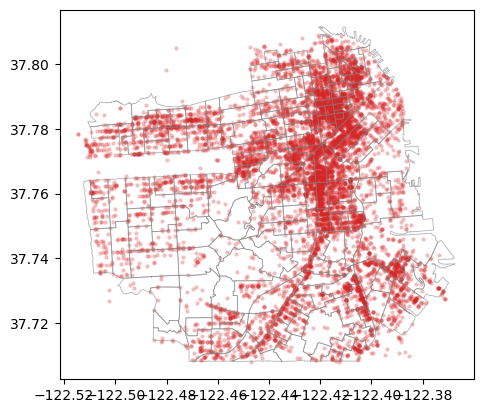

In [109]:
ax = land_populated_df.exterior.plot(linewidth=.6, color="grey", alpha=.6)
gdf.sample(10000).plot(ax=ax, color="tab:red", marker=".", alpha=.3, linewidth=0)
# cx.add_basemap(ax, crs=gdf_clean.crs)

In [78]:
for col in land_populated_df.columns:
    if col.startswith("Total_Not_Hispanic_or_Latino"):
        land_populated_df[col+"%"] = land_populated_df[col] / land_populated_df['Total_Not_Hispanic_or_Latino']
    elif col.startswith("Total_Hispanic_or_Latino"):
        land_populated_df[col+"%"] = land_populated_df[col] / land_populated_df['Total']


In [81]:
jointracts = gpd.sjoin(left_df=gdf,
                       right_df=land_populated_df,
                       how='left')


In [94]:
tract_count = (jointracts['TRACTCE']
               .value_counts()
               .reset_index()
               .rename({"TRACTCE": "Count"}, axis=1)
               )

In [95]:
merged_df = land_populated_df.merge(tract_count, left_on="index", right_on="TRACTCE")

In [108]:
(merged_df[['Count'] +
           [col for col in merged_df.columns if col.endswith("%")]]
 .corr()['Count']
 .sort_values()
 )

Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone%                                -0.084213
Total_Not_Hispanic_or_Latino_White_alone%                                                                     -0.024044
Total_Not_Hispanic_or_Latino_Two_or_more_races_Two_races_excluding_Some_other_race_and_three_or_more_races%   -0.014242
Total_Not_Hispanic_or_Latino_Two_or_more_races%                                                               -0.003049
Total_Not_Hispanic_or_Latino_Asian_alone%                                                                     -0.002999
Total_Not_Hispanic_or_Latino_Some_other_race_alone%                                                            0.000729
Total_Not_Hispanic_or_Latino_Black_or_African_American_alone%                                                  0.064580
Total_Not_Hispanic_or_Latino_Two_or_more_races_Two_races_including_Some_other_race%                            0.066868
Total_Not_Hispanic_or_Latino_American_In